In [1]:
from dpks.quant_matrix import QuantMatrix

import pandas as pd
import numpy as np

In [2]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)

In [4]:
design_matrix['sample_num'] = design_matrix.index.values

Now, we simulate 3 groups in the data so we can perform multiple rounds of explanations

In [5]:
design_matrix['group'] = np.where(
    design_matrix['sample_num'] < 50, 3, design_matrix['group']
)

In [6]:
design_matrix['group'].value_counts()

group
1    74
2    73
3    50
Name: count, dtype: int64

In [7]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).filter()

In [8]:
quantified_data = (
    qm.normalize(
        method="mean",
        use_rt_sliding_window_filter=True,
        rt_unit="second",
        stride=5,
        minimum_data_points=200,
    )
)

In [9]:
quantified_data = (
    quantified_data.quantify(
        method="maxlfq",
        threads=4,
        #top_n=5
    )
    .impute(
        method="uniform_percentile",
        percentile=0.05
    )
    .compare(
        method="linregress",
        min_samples_per_group=2,
        comparisons=[(2, 1), (3, 1)]
    )
)

/home/aaron/projects/dpks/DPKS/dpks/quantification.py:275: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

In [11]:
quantified_data = quantified_data.explain(
    clf,
    comparisons=[(2, 1), (3, 1)],
    n_iterations=10,
    downsample_background=True
)

In [12]:
quantified_data = quantified_data.annotate()

In [13]:
quantified_data.row_annotations.sort_values("MeanImportance2-1", ascending=False)

,Protein,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,...,Log2FoldChange3-1,PValue3-1,Group3RepCounts,CorrectedPValue3-1,-Log10CorrectedPValue3-1,MeanImportance2-1,MeanRank2-1,MeanImportance3-1,MeanRank3-1,Gene
425,P01880,0.199326,20.055612,20.684577,2.530866,2.876832,-0.628964,1.645325e-01,73,74,...,-1.105331,2.578480e-02,50,3.861991e-02,1.413189,0.919485,2.3,0.438687,81.9,IGHD
175,P08185,0.318725,21.797357,21.442865,0.355132,0.456388,0.354492,6.222475e-07,73,74,...,0.097467,2.251410e-01,50,2.110089e-01,0.675699,0.785799,8.6,0.170227,304.1,SERPINA6
39,Q04756,0.206384,18.980452,19.328303,0.581975,0.523915,-0.347850,2.254583e-04,73,74,...,-0.425968,1.033786e-05,50,4.524490e-05,4.344430,0.773799,7.7,0.537473,54.5,HGFAC
41,P06727,0.644203,23.411820,22.201168,0.955164,1.029708,1.210652,1.427511e-11,73,74,...,0.845627,1.752732e-06,50,9.683129e-06,5.013984,0.750845,9.2,0.869127,5.7,APOA4
151,P16070,1.054427,20.535027,19.460412,0.609436,0.539891,1.074615,1.761939e-21,73,74,...,1.037115,7.571437e-17,50,4.252624e-15,14.371343,0.747241,9.1,0.722093,20.3,CD44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,P01605,0.410266,25.461378,24.245838,1.787716,2.290502,1.215540,5.035324e-04,73,74,...,0.818310,3.289746e-02,50,4.717635e-02,1.326276,0.040176,486.6,0.033860,498.0,IGKV1D-33
455,P07359,0.136444,19.316287,18.949973,0.978536,1.005406,0.366314,2.777056e-02,73,74,...,0.067287,6.775172e-01,50,4.776638e-01,0.320878,0.038914,486.5,0.068631,433.9,GP1BA
462,P28066,0.235951,15.700316,14.967503,2.312632,2.252416,0.732813,5.518990e-02,73,74,...,0.032581,9.300842e-01,50,5.902794e-01,0.228942,0.038130,483.6,0.129358,338.4,PSMA5
523,Q71U36,0.064455,15.312078,15.513945,1.793029,1.813794,-0.201867,5.014534e-01,73,74,...,-0.431387,1.742563e-01,50,1.727188e-01,0.762660,0.034402,493.5,0.081966,411.7,TUBA1A


In [14]:
quantified_data.row_annotations['-log(p)'] = - np.log(quantified_data.row_annotations['CorrectedPValue2-1'])

In [15]:
import seaborn as sns

<Axes: xlabel='Log2FoldChange2-1', ylabel='-log(p)'>

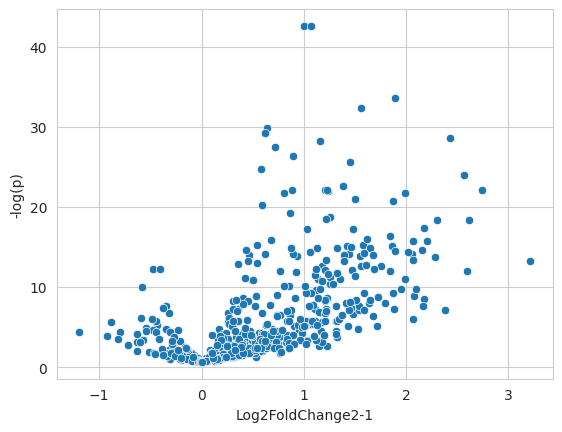

In [16]:
sns.scatterplot(
    data=quantified_data.row_annotations,
    x="Log2FoldChange2-1",
    y="-log(p)"
)

In [17]:
quantified_data.row_annotations['InverseRank2-1'] = 1 / quantified_data.row_annotations['MeanRank2-1']

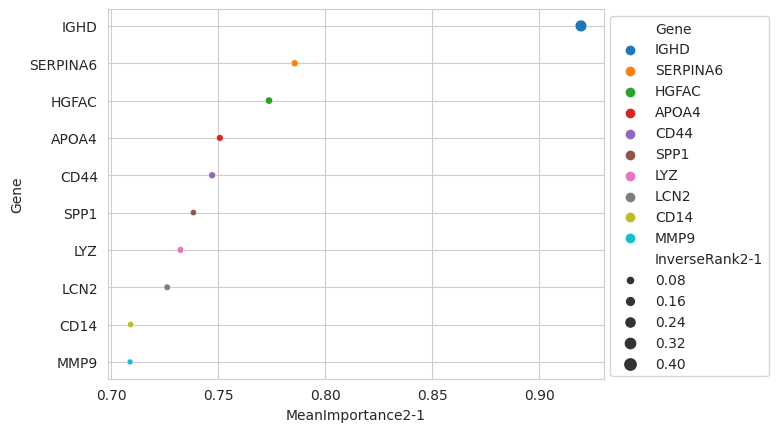

In [18]:
ax = sns.scatterplot(
    data=quantified_data.row_annotations.sort_values("MeanImportance2-1", ascending=False).head(10),
    x="MeanImportance2-1",
    y="Gene",
    hue="Gene",
    size="InverseRank2-1",
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

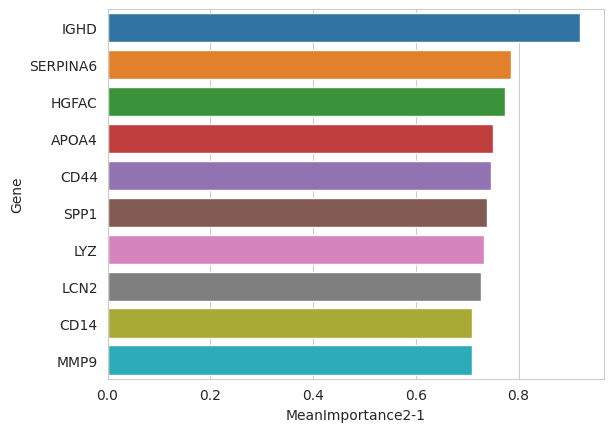

In [19]:
ax = sns.barplot(
    data=quantified_data.row_annotations.sort_values("MeanImportance2-1", ascending=False).head(10),
    x="MeanImportance2-1",
    y="Gene",
    hue_order="Gene",
)

<Axes: xlabel='MeanImportance2-1', ylabel='-log(p)'>

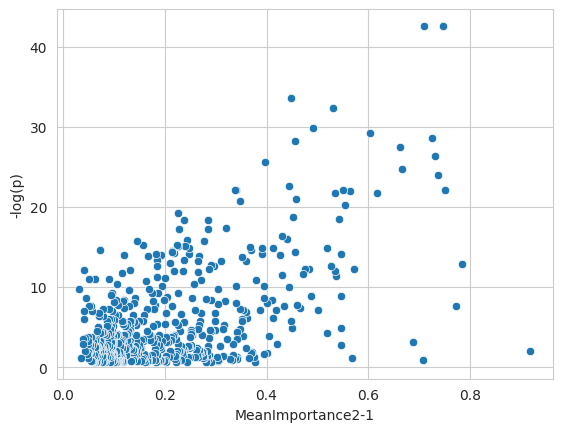

In [20]:
sns.scatterplot(
    data=quantified_data.row_annotations.sort_values("MeanImportance2-1", ascending=False),
    y="-log(p)",
    x="MeanImportance2-1",
)